In [1]:
import numpy as np
import pandas as pd
import math
import random
import csv
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [2]:
def FindIntersection(model1,model2):
    x =  (model1[1] - model2[1])/(model2[0] - model1[0])
    y =  model1[0]*x + model1[1]
    return [round(x,2), round(y,2)]

In [3]:
def GenerateLineModels(data,labels):    
    # fitting regression lines using the polyfit function for each cluster
    model = np.zeros(shape=(4,2))
    for i in range(4):
        model[i,:] = np.polyfit(data[labels==i,0], data[labels==i,1],1)
   
    # sorting the lines according to the slope of the regression lines
    s = np.array([model[0,0], model[1,0], model[2,0], model[3,0]]) 
    index = np.argsort(s)
    
    model = model[index,:]
    
    return model

In [4]:
def GenerateIntersectionPoints(model):
    # finding intersection of the first two lines with the last two lines
    # as there are pairs of parallel lines
    dat = []
    dat.append(FindIntersection(model[0,:],model[2,:]))        
    dat.append(FindIntersection(model[0,:],model[3,:]))  
    dat.append(FindIntersection(model[1,:],model[2,:]))        
    dat.append(FindIntersection(model[1,:],model[3,:]))
   
    # arranging lines in a counter clockwise order using convex hull
    dat = np.array(dat)
    hull = ConvexHull(dat)
    
    # finding the index of the coordinates with lowest y value 
    # to have as starting point
    ind = np.argmin(dat[hull.vertices,1])
    sorting_indices = hull.vertices

    # starting the coordinates with the vertex found
    if (ind ==1):
        sorting_indices = [1,2,3,0]
        
    if (ind ==2):
        sorting_indices = [2,3,0,1]
        
    if (ind ==3):
        sorting_indices = [3,0,1,2] 
        
    sorting_indices = hull.vertices[sorting_indices]
    
    return dat[sorting_indices,:].ravel()

In [12]:
def FindRectangleCoordinates(data,labels):
    model = GenerateLineModels(data,labels)
    return GenerateIntersectionPoints(model)

In [13]:
def GMM(data):
    gmm = GaussianMixture(n_components=4, n_init=100)
    gmm.fit(data)

    #predictions from gmm
    return gmm.predict(data)

In [14]:
def EstimateRectangle(x,y):
    # The first coordinate of the rectangle (x1,y1) is the lowest, that is, the y1 is minimum. 
    # If there are two lowest, then the first one is the left one out of the two.
    # All other coordinare are counter clockwise from that point

    data = np.zeros((x.shape[0],2))
    data[:,0] =x
    data[:,1] =y
    
    #predictions from gmm
    labels = GMM(data)

    return FindRectangleCoordinates(data,labels)

In [15]:
num = 100

In [16]:
#RMSE across all hundred sets of rectangle points
def EstimateRMSE(output, ground_truth):
    err = 0;
    f1 = open(output, "r")
    f2 = open(ground_truth, "r")
    for i in range(num):
        p1 = np.array(f1.readline().split(","),dtype='float')
        p2 = np.array(f2.readline().split(","),dtype='float')
        err = err + np.sum((p1-p2)*(p1-p2))
    return round(math.sqrt(err/(4*num)),2)

In [17]:
#RMSE across within each rectangle
def EstimateRMSE2(output, ground_truth):
    err = np.zeros(num)
    f1 = open(output, "r")
    f2 = open(ground_truth, "r")    
    for i in range(num):
        p1 = np.array(f1.readline().split(","),dtype='float')
        p2 = np.array(f2.readline().split(","),dtype='float')
        err[i] = round(math.sqrt(np.sum((p1-p2)*(p1-p2))/4),2)
    return err

In [18]:
f = open("training_data.csv", "r")
with open('output_train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for i in range(num):
        x = np.array(f.readline().split(","),dtype='float')
        y = np.array(f.readline().split(","),dtype='float')        
        [x1,y1,x2,y2,x3,y3,x4,y4] = EstimateRectangle(x,y)
        writer.writerow([x1,y1,x2,y2,x3,y3,x4,y4])
file.close()
f.close()

In [19]:
EstimateRMSE("output_train.csv","train_ground_truth.csv")

35.64

In [20]:
EstimateRMSE2("output_train.csv","train_ground_truth.csv")

array([16.62, 16.31, 20.78, 21.42, 26.34, 33.  , 36.91, 24.36, 19.48,
       63.37, 10.95, 19.92, 45.65, 22.12, 22.55, 50.96, 35.1 , 37.  ,
       41.41, 41.42, 76.49, 41.85, 34.13, 24.64, 36.04, 20.46, 48.74,
       63.27, 37.33, 24.49, 32.35, 35.52, 10.47, 30.68, 37.31, 58.38,
       26.53, 37.34, 22.56, 27.63, 20.53, 21.51, 22.61, 29.25, 31.96,
       26.07, 16.89, 28.16, 42.4 , 12.6 , 24.89, 31.21, 38.7 , 46.4 ,
       32.27, 44.49, 39.8 , 36.42, 15.6 , 36.11, 91.44, 30.97, 20.95,
       30.32, 49.21, 25.15, 26.48, 41.28, 29.09, 49.37, 44.06, 20.78,
       25.9 , 16.02, 46.06, 38.56, 41.35, 20.3 , 51.88, 48.35, 29.65,
       28.07, 48.53, 25.32, 38.74, 16.92, 27.6 , 30.17, 57.03, 28.89,
       19.63, 18.89, 30.9 , 26.22, 24.61, 35.65, 38.36, 27.83, 41.19,
       25.62])

In [21]:
data = np.zeros((x.shape[0],2))
data[:,0] =x
data[:,1] =y

#predictions from gmm
labels = GMM(data)

# fitting regression lines using the polyfit function for each cluster
model = np.zeros(shape=(4,2))
for i in range(4):
    model[i,:] = np.polyfit(data[labels==i,0], data[labels==i,1],1)

# sorting the lines according to the slope of the regression lines
s = np.array([model[0,0], model[1,0], model[2,0], model[3,0]]) 
index = np.argsort(s)

model = model[index,:]

# finding intersection of the first two lines with the last two lines
# as there are pairs of parallel lines
dat = []
dat.append(FindIntersection(model[0,:],model[2,:]))        
dat.append(FindIntersection(model[0,:],model[3,:]))  
dat.append(FindIntersection(model[1,:],model[2,:]))        
dat.append(FindIntersection(model[1,:],model[3,:]))

# arranging lines in a counter clockwise order using convex hull
dat = np.array(dat)
hull = ConvexHull(dat)

# finding the index of the coordinates with lowest y value 
# to have as starting point
ind = np.argmin(dat[hull.vertices,1])
sorting_indices = hull.vertices

# starting the coordinates with the vertex found
if (ind ==1):
    sorting_indices = [1,2,3,0]

if (ind ==2):
    sorting_indices = [2,3,0,1]

if (ind ==3):
    sorting_indices = [3,0,1,2] 

sorting_indices = hull.vertices[sorting_indices]

result = dat[sorting_indices,:].ravel()

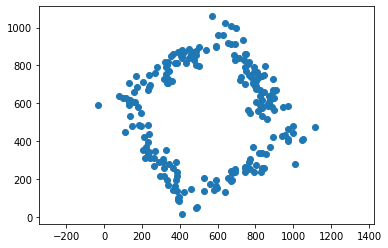

In [22]:
import matplotlib.pyplot as plt

plt.axis('equal')
plt.scatter(data[:,0], data[:,1])
plt.show()

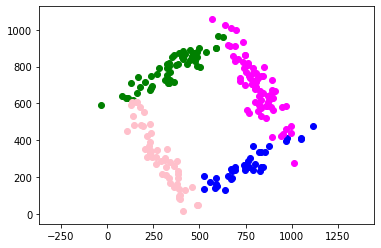

In [23]:
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['X', 'Y', 'cluster']

import matplotlib.pyplot as plt

plt.axis('equal')
color=['blue','green','magenta', 'pink']
for k in range(0,4):
    dat = frame[frame["cluster"]==k]
    plt.scatter(dat["X"],dat["Y"],c=color[k])
plt.show()

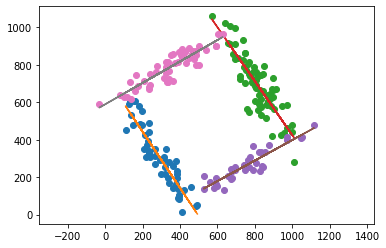

In [24]:
from matplotlib import pyplot as plt
plt.axis('equal')

xs = data[labels==index[0],0]
ys = data[labels==index[0],1]
trend = model[0,:]
plt.plot(xs,ys,'o')
trendpoly = np.poly1d(trend) 
plt.plot(xs,trendpoly(xs))

xs = data[labels==index[1],0]
ys = data[labels==index[1],1]
trend = model[1,:]
plt.plot(xs,ys,'o')
trendpoly = np.poly1d(trend) 
plt.plot(xs,trendpoly(xs))

xs = data[labels==index[2],0]
ys = data[labels==index[2],1]
trend = model[2,:]
plt.plot(xs,ys,'o')
trendpoly = np.poly1d(trend) 
plt.plot(xs,trendpoly(xs))

xs = data[labels==index[3],0]
ys = data[labels==index[3],1]
trend = model[3,:]
plt.plot(xs,ys,'o')
trendpoly = np.poly1d(trend) 
plt.plot(xs,trendpoly(xs))